<a href="https://colab.research.google.com/github/alex-movila/cnn/blob/master/FashionMINST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# load dataset from keras datasets

from keras.datasets import fashion_mnist
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

Load the Data
Keras comes with a library called datasets, which you can use to load datasets out of the box: you download the data from the server and speeds up the process since you no longer have to download the data to your computer. The train and test images along with the labels are loaded and stored in variables train_X, train_Y, test_X, test_Y, respectively.

In [41]:
# print number of samples and image sizes

import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

print('Training data shape : ', train_X.shape, train_Y.shape)

print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


From the above output, you can see that the training data has a shape of 60000 x 28 x 28 since there are 60,000 training samples each of 28 x 28 dimension. Similarly, the test data has a shape of 10000 x 28 x 28 since there are 10,000 testing samples.

In [42]:
# Find the unique numbers from the train labels
classes = np.unique(train_Y)
num_classes = len(classes)
print('Total number of outputs : ', num_classes)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


There's also a total of ten output classes that range from 0 to 9.

Text(0.5, 1.0, 'Ground Truth : 9')

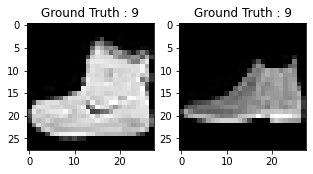

In [43]:
#We take a look at the images in dataset.

plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

We take a look at the images in dataset.

The output of above two plots looks like an ankle boot, and this class is assigned a class label of 9. Similarly, other fashion products will have different labels, but similar products will have same labels. This means that all the 7,000 ankle boot images will have a class label of 9.

As you could see in the above plot, the images are grayscale images have pixel values that range from 0 to 255. Also, these images have a dimension of 28 x 28. As a result, you'll need to preprocess the data before you feed it into the model

In [44]:
#Data Preprocessing

#convert each 28 x 28 image of the train and test set into a matrix of size 28 x 28 x 1 which is fed into the network
train_X = train_X.reshape(-1, 28,28, 1)
test_X = test_X.reshape(-1, 28,28, 1)
train_X.shape, test_X.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

The data right now is in an int8 format, so before you feed it into the network you need to convert its type to float32, and you also have to rescale the pixel values in range 0 - 1 inclusive.

In [45]:
#convert its type to float32, and you also have to rescale the pixel values in range 0 - 1 inclusive
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

In one-hot encoding, you convert the categorical data into a vector of numbers. The reason why you convert the categorical data in one hot encoding is that machine learning algorithms cannot work with categorical data directly. You generate one boolean column for each category or class. Only one of these columns could take on the value 1 for each sample. Hence, the term one-hot encoding.

For your problem statement, the one hot encoding will be a row vector, and for each image, it will have a dimension of 1 x 10. The important thing to note here is that the vector consists of all zeros except for the class that it represents, and for that, it is 1. For example, the ankle boot image that you plotted above has a label of 9, so for all the ankle boot images, the one hot encoding vector would be [0 0 0 0 0 0 0 0 1 0].

In [46]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


This last step is a crucial one. In machine learning or any data specific task, you should partition the data correctly. For the model to generalize well, you split the training data into two parts, one designed for training and another one for validation. In this case, you will train the model on 80% of the training data and validate it on 20% of the remaining training data. This will also help to reduce overfitting since you will be validating the model on the data it would not have seen in training phase, which will help in boosting the test performance.

In [47]:
#split the training data into two parts, one designed for training 80 and another one for validation 20

from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [48]:
#For one last time let's check the shape of training and validation set.

train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

You'll use three convolutional layers:

The first layer will have 32-3 x 3 filters,
The second layer will have 64-3 x 3 filters and
The third layer will have 128-3 x 3 filters.
In addition, there are three max-pooling layers each of size 2 x 2.

![alt text](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1512486717/fashion-mnist-architecture_htbpsz.png)


In [49]:
#Import for defining the network

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU




In Keras, you can just stack up layers by adding the desired layer one by one. That's exactly what you'll do here: you'll first add a first convolutional layer with Conv2D(). Note that you use this function because you're working with images! Next, you add the Leaky ReLU activation function which helps the network learn non-linear decision boundaries. Since you have ten different classes, you'll need a non-linear decision boundary that could separate these ten classes which are not linearly separable.

More specifically, you add Leaky ReLUs because they attempt to fix the problem of dying Rectified Linear Units (ReLUs). The ReLU activation function is used a lot in neural network architectures and more specifically in convolutional networks, where it has proven to be more effective than the widely used logistic sigmoid function. As of 2017, this activation function is the most popular one for deep neural networks. The ReLU function allows the activation to be thresholded at zero. However, during the training, ReLU units can "die". This can happen when a large gradient flows through a ReLU neuron: it can cause the weights to update in such a way that the neuron will never activate on any data point again. If this happens, then the gradient flowing through the unit will forever be zero from that point on. Leaky ReLUs attempt to solve this: the function will not be zero but will instead have a small negative slope.

Next, you'll add the max-pooling layer with MaxPooling2D() and so on. The last layer is a Dense layer that has a softmax activation function with 10 units, which is needed for this multi-class classification problem.

In [50]:
#define the network

fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(Dense(num_classes, activation='softmax'))

After the model is created, you compile it using the Adam optimizer, one of the most popular optimization algorithms. You can read more about this optimizer here. Additionally, you specify the loss type which is categorical cross entropy which is used for multi-class classification, you can also use binary cross-entropy as the loss function. Lastly, you specify the metrics as accuracy which you want to analyze while the model is training.

In [51]:
#Compile the Model
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [52]:
# visualize the layers
fashion_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 128)        

You will use a batch size of 64 using a higher batch size of 128 or 256 is also preferable it all depends on the memory. It contributes massively to determining the learning parameters and affects the prediction accuracy. You will train the network for 20 epochs.

In [53]:
batch_size = 64
epochs = 20


#train the model
fashion_train = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
750/750 [==============================] - 4s 5ms/step - loss: 0.6796 - accuracy: 0.7518 - val_loss: 0.3233 - val_accuracy: 0.8851
Epoch 2/20
750/750 [==============================] - 3s 4ms/step - loss: 0.2934 - accuracy: 0.8925 - val_loss: 0.2678 - val_accuracy: 0.9018
Epoch 3/20
750/750 [==============================] - 3s 4ms/step - loss: 0.2516 - accuracy: 0.9077 - val_loss: 0.2592 - val_accuracy: 0.9051
Epoch 4/20
750/750 [==============================] - 3s 4ms/step - loss: 0.2051 - accuracy: 0.9256 - val_loss: 0.2268 - val_accuracy: 0.9165
Epoch 5/20
750/750 [==============================] - 3s 4ms/step - loss: 0.1778 - accuracy: 0.9353 - val_loss: 0.2571 - val_accuracy: 0.9078
Epoch 6/20
750/750 [==============================] - 3s 4ms/step - loss: 0.1554 - accuracy: 0.9423 - val_loss: 0.2328 - val_accuracy: 0.9178
Epoch 7/20
750/750 [==============================] - 3s 4ms/step - loss: 0.1351 - accuracy: 0.9492 - val_loss: 0.2418 - val_accuracy: 0.9207
Epoch 

In [54]:
#Model Evaluation on the Test Set
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.48653462529182434
Test accuracy: 0.9103000164031982


The test accuracy looks impressive. It turns out that your classifier does better than the benchmark that was reported here, which is an SVM classifier with mean accuracy of 0.897. Also, the model does well compared to some of the deep learning models mentioned on the GitHub profile of the creators of fashion-MNIST dataset.

However, you saw that the model looked like it was overfitting. Are these results really all that good?

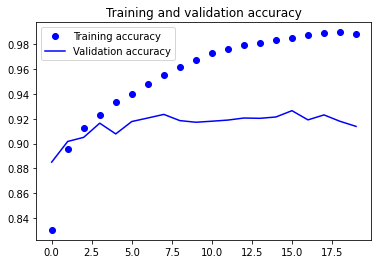

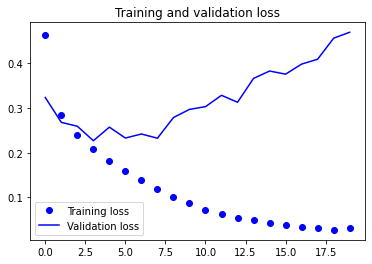

In [55]:
#Let's put your model evaluation into perspective and plot the accuracy and loss plots between training and validation data
accuracy = fashion_train.history['accuracy']
val_accuracy = fashion_train.history['val_accuracy']
loss = fashion_train.history['loss']
val_loss = fashion_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

From the above two plots, you can see that the validation accuracy almost became stagnant after 4-5 epochs and rarely increased at certain epochs. In the beginning, the validation accuracy was linearly increasing with loss, but then it did not increase much.

The validation loss shows that this is the sign of overfitting, similar to validation accuracy it linearly decreased but after 4-5 epochs, it started to increase. This means that the model tried to memorize the data and succeeded.

With this in mind, it's time to introduce some dropout into our model and see if it helps in reducing overfitting.

You can add a dropout layer to overcome the problem of overfitting to some extent. Dropout randomly turns off a fraction of neurons during the training process, reducing the dependency on the training set by some amount. How many fractions of neurons you want to turn off is decided by a hyperparameter, which can be tuned accordingly. This way, turning off some neurons will not allow the network to memorize the training data since not all the neurons will be active at the same time and the inactive neurons will not be able to learn anything.

In [56]:
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(28,28,1)))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.4))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))           
fashion_model.add(Dropout(0.3))
fashion_model.add(Dense(num_classes, activation='softmax'))

fashion_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 64)         

In [57]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [58]:
batch_size = 64
epochs = 20
fashion_train_dropout = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
750/750 [==============================] - 4s 5ms/step - loss: 0.8790 - accuracy: 0.6706 - val_loss: 0.3773 - val_accuracy: 0.8641
Epoch 2/20
750/750 [==============================] - 3s 5ms/step - loss: 0.3952 - accuracy: 0.8554 - val_loss: 0.3082 - val_accuracy: 0.8857
Epoch 3/20
750/750 [==============================] - 3s 5ms/step - loss: 0.3355 - accuracy: 0.8765 - val_loss: 0.2740 - val_accuracy: 0.8997
Epoch 4/20
750/750 [==============================] - 3s 5ms/step - loss: 0.3050 - accuracy: 0.8879 - val_loss: 0.2606 - val_accuracy: 0.9015
Epoch 5/20
750/750 [==============================] - 3s 5ms/step - loss: 0.2874 - accuracy: 0.8932 - val_loss: 0.2537 - val_accuracy: 0.9052
Epoch 6/20
750/750 [==============================] - 3s 5ms/step - loss: 0.2715 - accuracy: 0.8998 - val_loss: 0.2614 - val_accuracy: 0.9021
Epoch 7/20
750/750 [==============================] - 3s 5ms/step - loss: 0.2634 - accuracy: 0.9043 - val_loss: 0.2477 - val_accuracy: 0.9082
Epoch 

In [59]:
#save the model
fashion_model.save("fashion_model_dropout.h5py")

INFO:tensorflow:Assets written to: fashion_model_dropout.h5py/assets


In [60]:
#Model Evaluation on the Test Set
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.2330 - accuracy: 0.9181
Test loss: 0.23297236859798431
Test accuracy: 0.9180999994277954


Wow! Looks like adding Dropout in our model worked, even though the test accuracy did not improve significantly but the test loss decreased compared to the previous results.

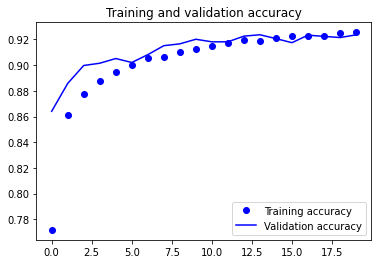

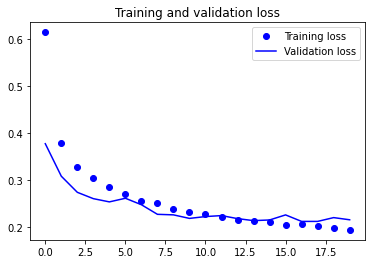

In [61]:
#let's plot the accuracy and loss plots between training and validation data for the one last time
accuracy = fashion_train_dropout.history['accuracy']
val_accuracy = fashion_train_dropout.history['val_accuracy']
loss = fashion_train_dropout.history['loss']
val_loss = fashion_train_dropout.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Finally, you can see that the validation loss and validation accuracy both are in sync with the training loss and training accuracy. Even though the validation loss and accuracy line are not linear, but it shows that your model is not overfitting: the validation loss is decreasing and not increasing, and there is not much gap between training and validation accuracy.

Therefore, you can say that your model's generalization capability became much better since the loss on both test set and validation set was only slightly more compared to the training loss.

In [62]:
#Predict Labels
predicted_classes = fashion_model.predict(test_X)

Since the predictions you get are floating point values, it will not be feasible to compare the predicted labels with true test labels. So, you will round off the output which will convert the float values into an integer. Further, you will use np.argmax() to select the index number which has a higher value in a row.

For example, let's assume a prediction for one test image to be 0100000000, the output for this should be a class label 1


Found 9137 correct labels


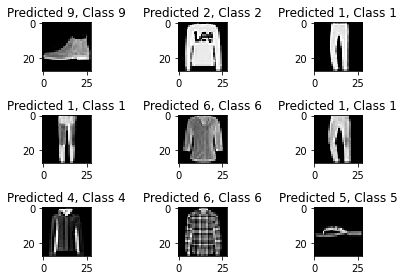

In [63]:
#compute no of correct labels
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_Y.shape
((10000,), (10000,))
correct = np.where(predicted_classes==test_Y)[0]
print( "Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_Y[correct]))
    plt.tight_layout()

Found 863 incorrect labels


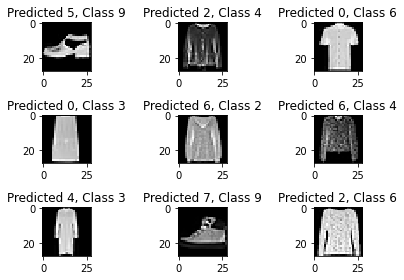

In [64]:
#compute no of incorrect labels
incorrect = np.where(predicted_classes!=test_Y)[0]
print( "Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]))
    plt.tight_layout()

Classification report will help us in identifying the misclassified classes in more detail. You will be able to observe for which class the model performed bad out of the given ten classes.

In [65]:
#@title
#Classification Report
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.76      0.90      0.83      1000
     Class 1       0.99      0.99      0.99      1000
     Class 2       0.82      0.92      0.87      1000
     Class 3       0.95      0.91      0.93      1000
     Class 4       0.89      0.83      0.86      1000
     Class 5       0.99      0.97      0.98      1000
     Class 6       0.84      0.68      0.75      1000
     Class 7       0.94      0.99      0.96      1000
     Class 8       0.99      0.99      0.99      1000
     Class 9       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



You can see that the classifier is underperforming for class 6 regarding both precision and recall. For class 0 and class 2, the classifier is lacking precision. Also, for class 4, the classifier is slightly lacking both precision and recall.